### Import packages

In [10]:
import enchant
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import sys

In [11]:
# Install large model

#!{sys.executable} -m pip install "https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.7.1/en_core_web_lg-3.7.1-py3-none-any.whl"
#!{sys.executable} -m spacy validate

# Do not use

In [12]:
# Install medium model
#!{sys.executable} -m pip install "https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.7.1/en_core_web_md-3.7.1-py3-none-any.whl"
#!{sys.executable} -m spacy validate

### Load and subset data

In [13]:
df = pd.read_csv("/home/domib/code/dominik-bulla/g0zzy/stress_sense/raw_data/Combined Data.csv", encoding="latin1")

In [14]:
df.columns

Index(['Unnamed: 0', 'statement', 'status'], dtype='object')

In [38]:
stress_posts = df[df['status'].isin(['Stress','Anxiety','Depression'])]
print(stress_posts.shape)
print(stress_posts.columns)
print(stress_posts.dtypes)
stress_posts.tail(200)

(21961, 3)
Index(['Unnamed: 0', 'statement', 'status'], dtype='object')
Unnamed: 0     int64
statement     object
status        object
dtype: object


,Unnamed: 0,statement,status
52843,52843,Just bought magnesium glycinateâ¦ does it rea...,Anxiety
52844,52844,Can you pass anxiety down to your children? I ...,Anxiety
52845,52845,Does anyone else hold off reading their messag...,Anxiety
52846,52846,Daily reminder. This is just a reminder that C...,Anxiety
52847,52847,I live with two people in my family who have s...,Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously Iâve (24M) dealt w...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


### Text Preprocessing

In [16]:
### lowercase
### dealing with numbers, punctuation, and symbols
### splitting
### tokenizing
### removing "stopwords"
### lemmatizing

nlp = spacy.load("en_core_web_md", disable=["ner", "parser", "textcat"])

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, language_model=nlp, min_len=1):
        self.nlp = language_model
        self.min_len = min_len  # optional length filter

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self._preprocess(x) for x in X]

    def _preprocess(self, text):
        # Missing values
        if text is None:
            return []
        if not isinstance(text, str):
            text = str(text)

        # lower case
        text = text.strip().lower()
        if not text:
            return []

        # dealing with numbers, punctuation, and symbols/stopwords/lemmatizing
        doc = self.nlp(text)
        tokens = [
            tok.lemma_
            for tok in doc
            if tok.is_alpha and not tok.is_stop
        ]

        doc = self.nlp(text)
        tokens = [
            tok.lemma_
            for tok in doc
            if tok.is_alpha
            and not tok.is_stop
            and len(tok) > 2         # drop very short leftovers
            and tok.lemma_ not in {"don", "t", "m"}  # custom contraction cleanup
        ]

        # Optional: drop very short results
        if len(tokens) < self.min_len:
            return []
        return tokens

text_pipeline = Pipeline([
    ("preprocessor", TextPreprocessor())
])


In [8]:
processed = text_pipeline.fit_transform(stress_posts["statement"])
processed = list(processed)  # in case it's a numpy array
stress_posts = stress_posts.copy()
stress_posts["processed_tokens"] = pd.Series(processed, index=stress_posts.index, dtype=object)

### Text vectorizing

In [9]:
tfidf = TfidfVectorizer(
    tokenizer=lambda x: x,     # take the list of tokens "as is"
    preprocessor=lambda x: x,  # don’t lowercase/clean again
    lowercase=False,
    ngram_range=(2, 2),
    max_features=1000,
    token_pattern=None
)

tokens = stress_posts["processed_tokens"].apply(lambda x: x if isinstance(x, list) else [])

vectorized_messages = tfidf.fit_transform(tokens)
vectorized_messages = pd.DataFrame(
    vectorized_messages.toarray(),
    columns = tfidf.get_feature_names_out()
)

### Finding best model

In [20]:
scores = []
perplexities = []
topics_range = range(3, 21, 3)

for k in topics_range:
    print(k)
    lda = LatentDirichletAllocation(
        n_components=k,
        max_iter=100,
        random_state=42,
        learning_method="batch"
    )
    lda.fit(vectorized_messages)
    scores.append(lda.score(vectorized_messages))
    perplexities.append(lda.perplexity(vectorized_messages))

3
6
9
12
15
18


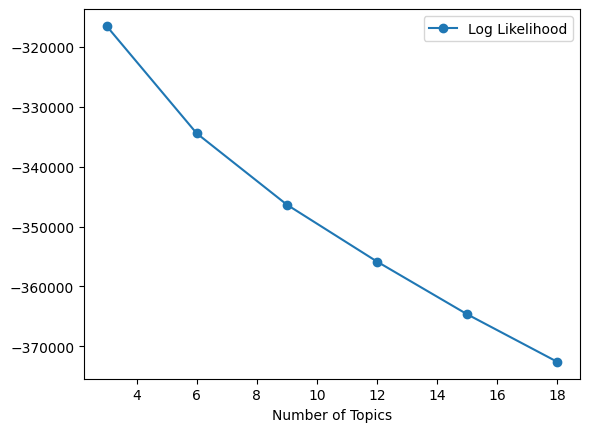

In [21]:
%matplotlib inline

plt.plot(topics_range, scores, marker="o", label="Log Likelihood")
#plt.plot(topics_range, perplexities, marker="x", label="Perplexity")
plt.xlabel("Number of Topics")
plt.legend()
plt.show()


### Train LDA Model

In [22]:
n_components = 6
lda_model = LatentDirichletAllocation(
    n_components=n_components,
    max_iter = 500,
    random_state=42)
lda_model.fit(vectorized_messages)
topics_mixture = lda_model.transform(vectorized_messages)

### link back to original dataframe 

In [23]:
def link_back(topics_mixture, stress_posts):

    topic_cols = [f"topic_{i}" for i in range(topics_mixture.shape[1])]
    topic_df = pd.DataFrame(topics_mixture, index=stress_posts.index, columns=topic_cols)

    stress_posts = stress_posts.copy()
    stress_posts["dominant_topic"] = topic_df.values.argmax(axis=1)
    stress_posts["dominant_weight"] = round(topic_df.max(axis=1),2)
    stress_posts["solution"] = np.where(
        stress_posts["dominant_weight"] > round(1/6,2), 1, 0
    )

    return stress_posts

In [24]:
stress_posts_6 = link_back(topics_mixture, stress_posts)

In [25]:
### proportion of proper solutions
print(round(np.multiply(stress_posts_6.solution.value_counts(normalize=True)[1], 100),2))


85.84


In [30]:
stress_posts_6[
    (stress_posts_6['status'] == "Stress") &
    (stress_posts_6['solution'] == 1)
]["dominant_topic"].value_counts()


dominant_topic
2    469
5    418
0    369
1    358
4    346
3    205
Name: count, dtype: int64

In [31]:
def print_topics(lda_model, vectorizer, top_words):
    topic_word_mixture = pd.DataFrame(
        lda_model.components_,
        columns = tfidf.get_feature_names_out()
    )
    n_components = topic_word_mixture.shape[0]

    for topic in range(n_components):
        print("-"*10)
        print(f"For topic {topic}, here are the the top {top_words} words with weights:")

        topic_df = topic_word_mixture.iloc[topic]\
            .sort_values(ascending = False).head(top_words)

        print(round(topic_df,3))

In [32]:
print_topics(lda_model, tfidf, 10)

----------
For topic 0, here are the the top 10 words with weights:
feel like             124.256
depression anxiety     91.870
day day                78.178
new job                68.251
year old               66.822
need talk              65.108
feel good              56.135
hour day               55.793
start new              55.418
lose job               55.349
Name: 0, dtype: float64
----------
For topic 1, here are the the top 10 words with weights:
mental health      162.103
fall asleep         77.563
look like           66.201
feel like           64.645
health issue        64.250
anti depressant     57.411
long term           52.659
stress anxiety      52.104
past month          50.132
today feel          49.787
Name: 1, dtype: float64
----------
For topic 2, here are the the top 10 words with weights:
feel like    858.177
make feel    143.826
feel bad     137.240
feel way     131.161
know feel    111.078
feel well    103.813
time feel     94.876
want feel     92.676
like feel 